In [1]:
#https://www.kaggle.com/pablocastilla/predict-stock-prices-with-lstm/notebook


In [94]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from subprocess import check_output
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from sklearn.cross_validation import  train_test_split
import time #helper libraries
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from numpy import newaxis

import os

In [42]:
LIB_DIR = "/home/ubuntu/fastai/fastai_bmt_reworking/bmt_library"
DATA_DIR = "/home/ubuntu/fastai/data/stock_data/"

In [90]:
os.chdir(LIB_DIR)
print ("current working directory:", os.getcwd())

%matplotlib inline
import yqd #library to access yahoo stock prices
import tools #library with misc tools for deep learning

('current working directory:', '/home/ubuntu/fastai/fastai_bmt_reworking/bmt_library')


In [11]:
def load_quote(ticker, start_date, end_date):
    # format: 'yyyymmdd'
	print('===', ticker, '===')
	results = yqd.load_yahoo_quote(ticker, start_date, end_date)
	print("results:", type(results))
	print(results)
	return results


In [47]:
stock = 'QCOM'
start_date = '20170101'
end_date = '20180109'
results = load_quote('QCOM', start_date, end_date)

('===', 'QCOM', '===')
('results:', <type 'list'>)
[u'Date,Open,High,Low,Close,Adj Close,Volume', u'2017-01-03,65.860001,66.139999,64.599998,65.400002,62.928608,9519800', u'2017-01-04,65.669998,65.949997,65.260002,65.470001,62.995956,6221700', u'2017-01-05,65.220001,65.980003,65.050003,65.550003,63.072941,5998900', u'2017-01-06,65.480003,65.870003,64.860001,65.529999,63.053688,6749400', u'2017-01-09,65.529999,66.269997,65.489998,65.650002,63.169151,4702100', u'2017-01-10,65.949997,66.160004,65.570000,65.629997,63.149918,6076000', u'2017-01-11,65.750000,66.110001,65.419998,66.099998,63.602150,8349800', u'2017-01-12,65.349998,66.180000,65.050003,66.120003,63.621403,6113600', u'2017-01-13,66.250000,67.080002,66.160004,66.879997,64.352676,6177400', u'2017-01-17,66.709999,66.970001,63.150002,64.190002,61.764332,22338800', u'2017-01-18,64.669998,66.089996,63.810001,65.129997,62.668804,15883200', u'2017-01-19,64.970001,65.400002,64.360001,64.440002,62.004887,9429200', u'2017-01-20,65.190002,6

In [48]:
type(results), len(results), type(results[0]), str(results[0]).split(","), str(results[1]).split(",")

(list,
 258,
 unicode,
 ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'],
 ['2017-01-03',
  '65.860001',
  '66.139999',
  '64.599998',
  '65.400002',
  '62.928608',
  '9519800'])

In [49]:
col_names = str(results[0]).split(",")
col_names

['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

In [50]:
df = pd.DataFrame(columns=col_names)
temp_list = []
for i in range(1,len(results)-1):
    res = str(results[i]).split(",")
    #print (i, ", res:", res)
    #print (type(res))
    temp_list.append(res)
df=pd.DataFrame(temp_list,columns=col_names)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-01-03,65.860001,66.139999,64.599998,65.400002,62.928608,9519800
1,2017-01-04,65.669998,65.949997,65.260002,65.470001,62.995956,6221700
2,2017-01-05,65.220001,65.980003,65.050003,65.550003,63.072941,5998900
3,2017-01-06,65.480003,65.870003,64.860001,65.529999,63.053688,6749400
4,2017-01-09,65.529999,66.269997,65.489998,65.650002,63.169151,4702100
5,2017-01-10,65.949997,66.160004,65.570000,65.629997,63.149918,6076000
6,2017-01-11,65.750000,66.110001,65.419998,66.099998,63.602150,8349800
7,2017-01-12,65.349998,66.180000,65.050003,66.120003,63.621403,6113600
8,2017-01-13,66.250000,67.080002,66.160004,66.879997,64.352676,6177400
9,2017-01-17,66.709999,66.970001,63.150002,64.190002,61.764332,22338800


In [51]:
file_name = stock+"_"+start_date+"_"+end_date+".csv"

In [56]:
df.to_csv(DATA_DIR+file_name, sep=',', index=False)

In [57]:
prices_dataset =  pd.read_csv(DATA_DIR+file_name)
prices_dataset.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-01-03,65.860001,66.139999,64.599998,65.400002,62.928608,9519800
1,2017-01-04,65.669998,65.949997,65.260002,65.470001,62.995956,6221700
2,2017-01-05,65.220001,65.980003,65.050003,65.550003,63.072941,5998900
3,2017-01-06,65.480003,65.870003,64.860001,65.529999,63.053688,6749400
4,2017-01-09,65.529999,66.269997,65.489998,65.650002,63.169151,4702100


In [64]:
stock_prices = prices_dataset.Close.values.astype('float32')
type(stock_prices), stock_prices.shape[0]

(numpy.ndarray, 256)

In [65]:
stock_prices = stock_prices.reshape(stock_prices.shape[0], 1)
type(stock_prices), stock_prices.shape

(numpy.ndarray, (256, 1))

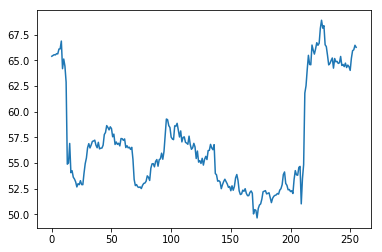

In [66]:
plt.plot(stock_prices)
plt.show()

In [100]:
scaler = MinMaxScaler(feature_range=(0, 1))
stock_prices = scaler.fit_transform(stock_prices)

In [67]:
train_size = int(len(stock_prices) * 0.80)
test_size = len(stock_prices) - train_size
print ("train_size:", train_size)
print ("test_size:", test_size)

('train_size:', 204)
('test_size:', 52)


In [68]:
train = stock_prices[0:train_size,:]
test  = stock_prices[train_size:len(stock_prices),:]
print (len(train))
print (len(test))

204
52


In [82]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		#print ("i:", i, ", a:", a)
		#select left column, row i to row i+look_back
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
		
    #convert to numpy arrays and return
	return np.array(dataX), np.array(dataY)

In [83]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
print ("trainX:", type(trainX), trainX.shape)
print ("trainY:", type(trainY), trainY.shape)
print ("testX:", type(testX), testX.shape)
print ("testY:", type(testY), testY.shape)

('trainX:', <type 'numpy.ndarray'>, (202, 1))
('trainY:', <type 'numpy.ndarray'>, (202,))
('testX:', <type 'numpy.ndarray'>, (50, 1))
('testY:', <type 'numpy.ndarray'>, (50,))


In [84]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print ("trainX:", trainX.shape)
print ("testX:", testX.shape)


('trainX:', (202, 1, 1))
('testX:', (50, 1, 1))


In [85]:
#Step 2 Build Model
model = Sequential()

model.add(LSTM( input_dim=1,
                output_dim=50,
                return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM( 100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(output_dim=1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mse', optimizer='rmsprop')
print ('compilation time : ', time.time() - start)

('compilation time : ', 0.006315946578979492)


In [86]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lstm_1 (LSTM)                    (None, None, 50)      10400       lstm_input_1[0][0]               
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, None, 50)      0           lstm_1[0][0]                     
____________________________________________________________________________________________________
lstm_2 (LSTM)                    (None, 100)           60400       dropout_1[0][0]                  
____________________________________________________________________________________________________
dropout_2 (Dropout)              (None, 100)           0           lstm_2[0][0]                     
___________________________________________________________________________________________

In [89]:
history = model.fit(trainX, trainY, batch_size=128, nb_epoch=10, validation_split=0.05, verbose=1)

Train on 191 samples, validate on 11 samples
Epoch 1/10
191/191 [==============================] - 0s - loss: 3079.0639 - val_loss: 2759.5083
Epoch 2/10
191/191 [==============================] - 0s - loss: 3058.5933 - val_loss: 2743.9077
Epoch 3/10
191/191 [==============================] - 0s - loss: 3040.7950 - val_loss: 2729.9819
Epoch 4/10
191/191 [==============================] - 0s - loss: 3027.8928 - val_loss: 2716.3640
Epoch 5/10
191/191 [==============================] - 0s - loss: 3011.6943 - val_loss: 2702.3311
Epoch 6/10
191/191 [==============================] - 0s - loss: 2999.3453 - val_loss: 2688.1052
Epoch 7/10
191/191 [==============================] - 0s - loss: 2983.5480 - val_loss: 2673.1636
Epoch 8/10
191/191 [==============================] - 0s - loss: 2969.8275 - val_loss: 2658.2480
Epoch 9/10
191/191 [==============================] - 0s - loss: 2952.2284 - val_loss: 2642.6479
Epoch 10/10
191/191 [==============================] - 0s - loss: 2937.8346 - val_

In [91]:
def plot_results_multiple(predicted_data, true_data,length):
    plt.plot(scaler.inverse_transform(true_data.reshape(-1, 1))[length:])
    plt.plot(scaler.inverse_transform(np.array(predicted_data).reshape(-1, 1))[length:])
    plt.show()

In [92]:
#predict lenght consecutive values from a real one
def predict_sequences_multiple(model, firstValue,length):
    prediction_seqs = []
    curr_frame = firstValue
    
    for i in range(length): 
        predicted = []        
        
        print(model.predict(curr_frame[newaxis,:,:]))
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        
        curr_frame = curr_frame[0:]
        curr_frame = np.insert(curr_frame[0:], i+1, predicted[-1], axis=0)
        
        prediction_seqs.append(predicted[-1])
        
    return prediction_seqs

In [95]:
predict_length=5
predictions = predict_sequences_multiple(model, testX[0], predict_length)


[[ 1.5269537]]
[[ 1.71269298]]
[[ 1.85741258]]
[[ 1.92493069]]
[[ 1.95577955]]


In [106]:
print(MinMaxScaler.inverse_transform(scaler, np.array(predictions).reshape(-1, 1)))
#this also produces same output
#print(scaler.inverse_transform(np.array(predictions).reshape(-1, 1)))
#MinMaxScaler.inverse_transform


[[ 79.06439972]
 [ 82.64360046]
 [ 85.43235016]
 [ 86.73342133]
 [ 87.32788086]]


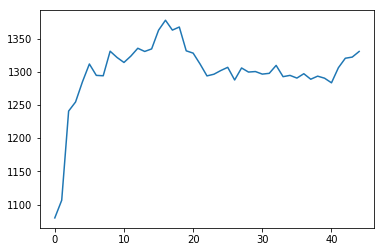

In [107]:
plot_results_multiple(predictions, testY, predict_length)